<a href="https://colab.research.google.com/github/anggara23-dotcom/ProjectML/blob/main/Ujian_SKPI_RIKO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Riko Adytia Anggara

NPM  : 23171065708

Project Prediksi Penjualan Menggunakan SARIMA

In [4]:
!pip uninstall -y numpy  # Hapus versi numpy yang bermasalah
!pip install --upgrade --no-cache-dir numpy==1.24.3 pmdarima

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 309.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.6.1 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
xarray-einstats 0.9.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
pymc 5.25.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
arviz 0.22.0 requires

In [5]:
import numpy as np
from pmdarima import auto_arima

print("Versi NumPy:", np.__version__)  # Pastikan versi 1.24.3
print("pmdarima berhasil diimpor!")

Versi NumPy: 1.24.3
pmdarima berhasil diimpor!


1. Proses Data Understanding

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime

In [7]:
df = pd.read_csv('dataset/ds_penjualan.csv', sep=';', index_col='Month')
df.index = pd.to_datetime(df.index, format='%m-%Y')

# Melihat df
display(df.head())


,Sales_qty
Month,
2015-01-01,112
2015-02-01,118
2015-03-01,132
2015-04-01,129
2015-05-01,121


Tabel di atas ini menampilkan data penjualan (Sales_qty) dari bulan Januari hingga Mei 2015. Setiap baris merepresentasikan total kuantitas penjualan pada bulan tertentu.


Dari data awal ini terlihat adanya fluktuasi jumlah penjualan dari bulan ke bulan. Misalnya, terjadi kenaikan signifikan dari Januari ke Maret (112 → 132), kemudian sedikit menurun di bulan April dan Mei. Pola ini dapat menjadi indikasi awal adanya pola musiman atau tren dalam data yang akan dianalisis lebih lanjut menggunakan metode peramalan deret waktu seperti ARIMA.

In [8]:
# Melihat info df

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2015-01-01 to 2025-04-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sales_qty  124 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


Hasil keluaran dari perintah df.info() menunjukkan bahwa data terdiri dari 124 entri penjualan bulanan dengan indeks waktu mulai dari Januari 2015 hingga April 2025. Kolom utama Sales_qty memiliki tipe data bilangan bulat (int64) dan tidak mengandung nilai kosong, sehingga layak digunakan dalam proses analisis deret waktu.

Keberadaan DatetimeIndex juga memastikan bahwa dataset telah sesuai format yang dibutuhkan untuk penerapan metode peramalan seperti SARIMA, yang mengandalkan keterurutan waktu dalam data.

In [9]:
# Melihat info df

df.describe()

,Sales_qty
count,124.000000
mean,250.104839
std,96.309530
min,104.000000
25%,171.750000
50%,235.000000
75%,317.250000
max,505.000000


Nilai rata-rata penjualan per bulan adalah sekitar 250 unit, dengan simpangan baku sebesar 96.31, yang menunjukkan tingkat variasi atau penyebaran data penjualan cukup besar dari nilai rata-rata. Nilai minimum dan maksimum berturut-turut adalah 104 dan 505, menunjukkan adanya fluktuasi yang signifikan antar periode.

Distribusi data juga menunjukkan bahwa 50% data berada di bawah nilai 235 (median), dan 75% data berada di bawah nilai 317.25. Hal ini bisa menjadi indikasi adanya nilai ekstrim (outlier) atau periode penjualan yang sangat tinggi di luar kebiasaan.

In [10]:
# Cek indeks df
display(df.index)

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01',
               ...
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01'],
              dtype='datetime64[ns]', name='Month', length=124, freq=None)

In [11]:
# Merubah indeks df menjadi 'MS'
df.index.freq = 'MS'
display(df.index)

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01',
               ...
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01'],
              dtype='datetime64[ns]', name='Month', length=124, freq='MS')

ProsesProses ini bertujuan memastikan data time series memiliki frekuensi yang terdefinisi dengan benar. Pada awalnya (freq=None), meskipun data terlihat berurutan bulanan, pandas tidak secara otomatis mengenali pola frekuensinya. Dengan menetapkan freq='MS', kita memberi tahu pandas bahwa data bersifat reguler (setiap awal bulan).

Tanpa frekuensi yang terdefinisi (freq=None), banyak fungsi pandas/statistics untuk time series tidak akan bekerja (misal: forecasting, resampling, atau pemeriksaan missing data).

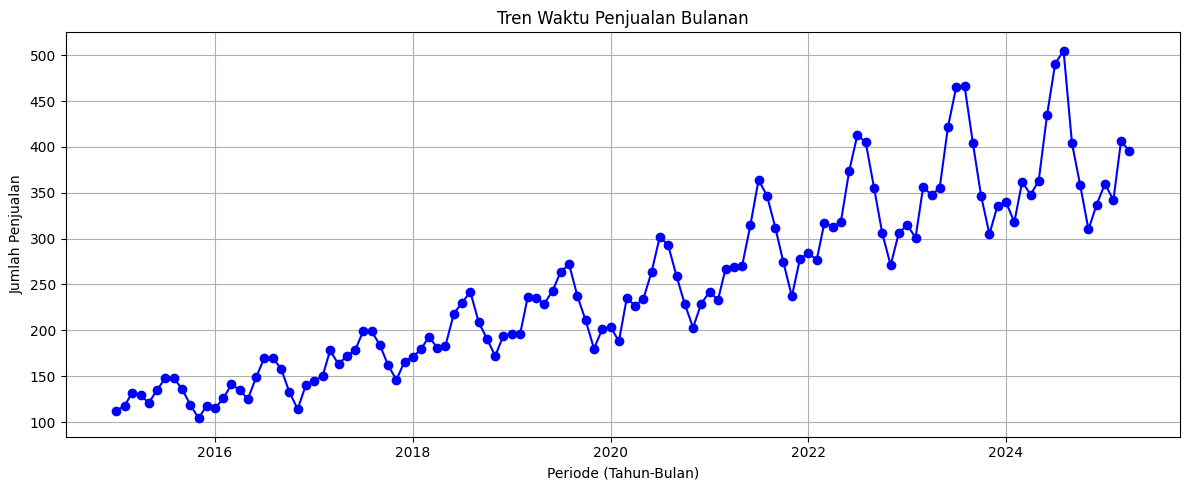

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Pastikan index sudah berupa datetime
df.index = pd.to_datetime(df.index)

# Visualisasi tren waktu
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Sales_qty'], marker='o', linestyle='-', color='blue')
plt.title('Tren Waktu Penjualan Bulanan')
plt.xlabel('Periode (Tahun-Bulan)')
plt.ylabel('Jumlah Penjualan')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualisasi Tren Waktu Penjualan Bulanan
Grafik di atas menggambarkan tren jumlah penjualan bulanan dari Januari 2015 hingga April 2025. Setiap titik merepresentasikan total penjualan (Sales_qty) pada masing-masing bulan.

Dari visualisasi tersebut, terlihat adanya tren peningkatan secara bertahap dalam jumlah penjualan sepanjang waktu. Secara umum, penjualan cenderung meningkat dari tahun ke tahun, yang menunjukkan adanya pertumbuhan bisnis yang konsisten.

Selain tren naik, grafik juga menunjukkan adanya pola musiman (seasonality) dengan fluktuasi berulang yang terjadi pada periode tertentu setiap tahun. Puncak dan lembah yang konsisten ini bisa menjadi indikasi adanya faktor musiman seperti promosi, musim belanja, atau pola permintaan pelanggan.

Pola naik-turun yang tajam pada beberapa titik juga mengindikasikan adanya volatilitas atau faktor eksternal yang mempengaruhi volume penjualan dalam jangka pendek.

Visualisasi ini sangat penting sebagai langkah awal dalam analisis deret waktu, khususnya dalam mengidentifikasi komponen tren, musiman, dan residu yang dapat dimodelkan lebih lanjut dengan pendekatan ARIMA atau SARIMA

<Figure size 1200x500 with 0 Axes>

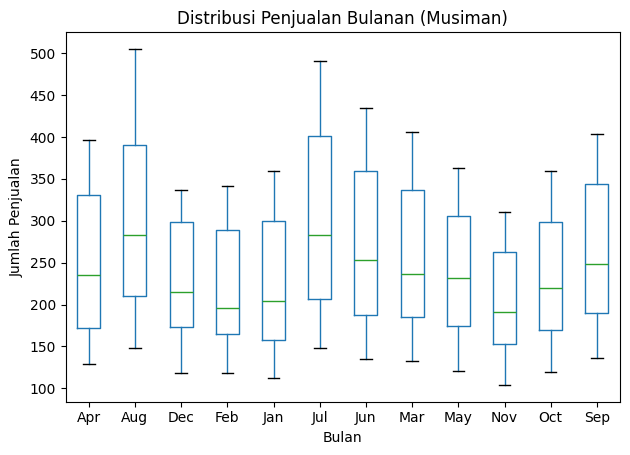

In [13]:
# Tambahkan kolom bulan dan tahun
df['Month_Num'] = df.index.month
df['Month_Name'] = df.index.strftime('%b')

# Boxplot musiman untuk melihat pola per bulan
plt.figure(figsize=(12, 5))
df.boxplot(column='Sales_qty', by='Month_Name', grid=False, showfliers=False)
plt.title('Distribusi Penjualan Bulanan (Musiman)')
plt.suptitle('')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Penjualan')
plt.tight_layout()
plt.show()

Distribusi Penjualan Bulanan (Musiman)
Grafik di atas menampilkan boxplot distribusi penjualan (Sales_qty) untuk setiap bulan, yang merepresentasikan variasi penjualan dalam siklus tahunan selama periode 2015–2025.

Beberapa temuan penting dari visualisasi ini:

Bulan Juli dan Agustus menunjukkan distribusi penjualan tertinggi dengan median yang tinggi serta rentang interkuartil yang lebar, menandakan adanya lonjakan penjualan musiman pada pertengahan tahun.
Bulan November dan Februari menunjukkan median yang lebih rendah dibandingkan bulan lainnya, yang menunjukkan bahwa penjualan cenderung lebih rendah di akhir dan awal tahun.
Bulan Maret hingga Juni memiliki distribusi yang cukup stabil, tanpa fluktuasi ekstrem.
Hampir setiap bulan menunjukkan adanya outlier (nilai ekstrim), mengindikasikan beberapa periode dengan penjualan yang tidak biasa (sangat tinggi atau rendah).
Visualisasi ini mendukung adanya pola musiman (seasonality) yang kuat, yang menjadi pertimbangan penting dalam pemilihan model deret waktu, misalnya menggunakan SARIMA atau SARIMAX untuk memodelkan faktor musiman secara eksplisit.

In [14]:
from scipy.stats import zscore

# Hitung z-score untuk kolom penjualan
df['z_score'] = zscore(df['Sales_qty'])

# Tandai sebagai anomali jika z-score lebih dari 3 atau kurang dari -3
df['anomaly'] = df['z_score'].apply(lambda x: abs(x) > 3)

# Tampilkan anomali
anomalies = df[df['anomaly']]

print("Anomali terdeteksi:")
print(anomalies[['Sales_qty', 'z_score']])

Anomali terdeteksi:
Empty DataFrame
Columns: [Sales_qty, z_score]
Index: []


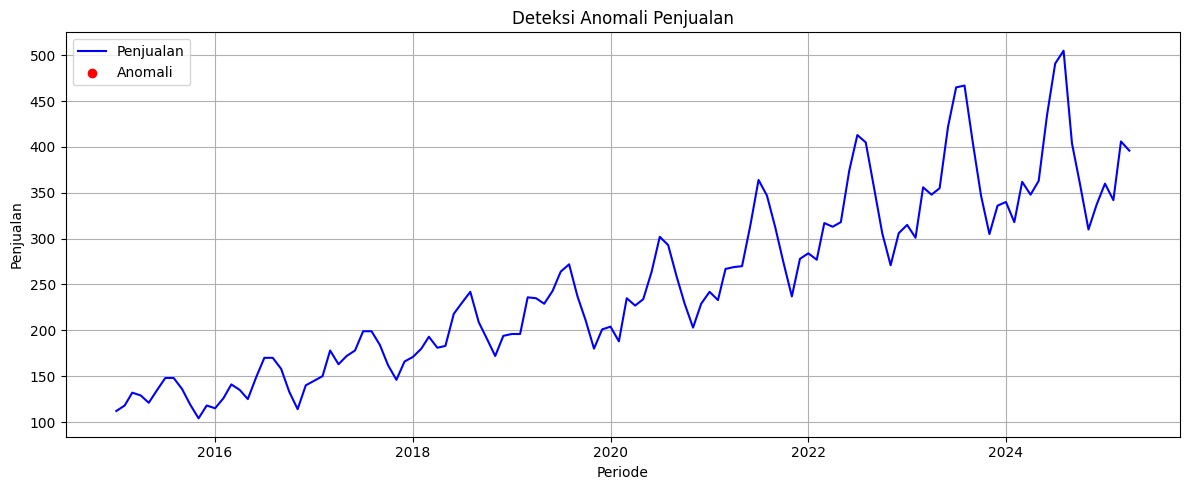

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Sales_qty'], label='Penjualan', color='blue')
plt.scatter(anomalies.index, anomalies['Sales_qty'], color='red', label='Anomali', zorder=5)
plt.title('Deteksi Anomali Penjualan')
plt.xlabel('Periode')
plt.ylabel('Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Deteksi Anomali Penjualan Bulanan
Grafik di atas menunjukkan hasil deteksi anomali pada data penjualan bulanan selama periode Januari 2015 hingga April 2025. Garis biru menunjukkan nilai aktual penjualan tiap bulan, sedangkan titik merah merepresentasikan anomali, yaitu nilai yang secara statistik menyimpang dari pola normal.

Beberapa hal yang dapat disimpulkan dari grafik ini:


*   Secara umum, tren penjualan tetap menunjukkan kenaikan bertahap seiring waktu.
*   Deteksi anomali ini sangat penting untuk pengambilan keputusan bisnis, karena dapat menandai periode keberhasilan atau potensi masalah yang memerlukan perhatian lebih lanjut.


Dengan adanya deteksi anomali, perusahaan dapat mengevaluasi kembali strategi operasional atau pemasaran yang telah dilakukan pada periode tersebut.

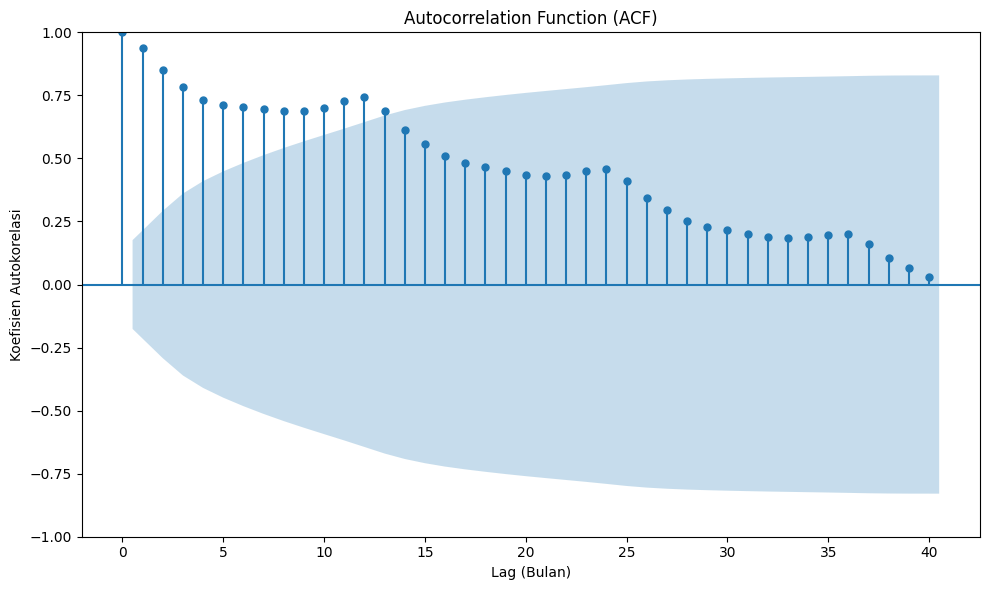

In [16]:
# --- Plot ACF ---
plt.figure(figsize=(10, 6))
plot_acf(df['Sales_qty'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag (Bulan)')
plt.ylabel('Koefisien Autokorelasi')


plt.tight_layout()
plt.show()

Grafik Autocorrelation Function (ACF)
Grafik di atas menampilkan hasil analisis Autocorrelation Function (ACF) terhadap data penjualan bulanan. ACF digunakan untuk mengukur sejauh mana nilai penjualan pada bulan tertentu berkorelasi dengan nilai pada bulan-bulan sebelumnya.

📌 Sumbu X – Lag (Bulan)
Sumbu horizontal menunjukkan nilai lag, yaitu jeda waktu dalam satuan bulan.

Lag 1 mengacu pada korelasi antara bulan ini dan bulan sebelumnya.
Lag 12 mengacu pada korelasi antara bulan ini dan bulan yang sama di tahun sebelumnya.

📌 Sumbu Y – Koefisien Autokorelasi
Sumbu vertikal menunjukkan nilai koefisien autokorelasi, yang berkisar dari -1 hingga 1:

Nilai mendekati +1 menunjukkan korelasi positif yang kuat.
Nilai 0 berarti tidak ada korelasi.
Nilai mendekati -1 menunjukkan korelasi negatif yang kuat.

📈 Interpretasi Grafik
Koefisien autokorelasi sangat tinggi pada lag 1 hingga 12, dengan nilai antara 0.7 hingga 0.9, menunjukkan adanya ketergantungan yang kuat antar bulan-bulan berdekatan.
Koefisien menurun perlahan seiring bertambahnya lag, tetapi masih tetap signifikan hingga sekitar lag ke-30.
Area biru merupakan interval kepercayaan 95%. Batang ACF yang melewati area ini dianggap signifikan secara statistik.
Pola ini mengindikasikan adanya trend jangka panjang dan kemungkinan pola musiman dalam data.

🧾 Kesimpulan
Grafik ACF ini menunjukkan bahwa:

Data bersifat non-stasioner, karena autokorelasi tinggi bertahan lama.
Diperlukan differencing (nilai d > 0) sebelum membangun model ARIMA.
Pola autokorelasi musiman (misalnya di lag 12) menunjukkan bahwa model SARIMA lebih cocok dibanding ARIMA biasa.

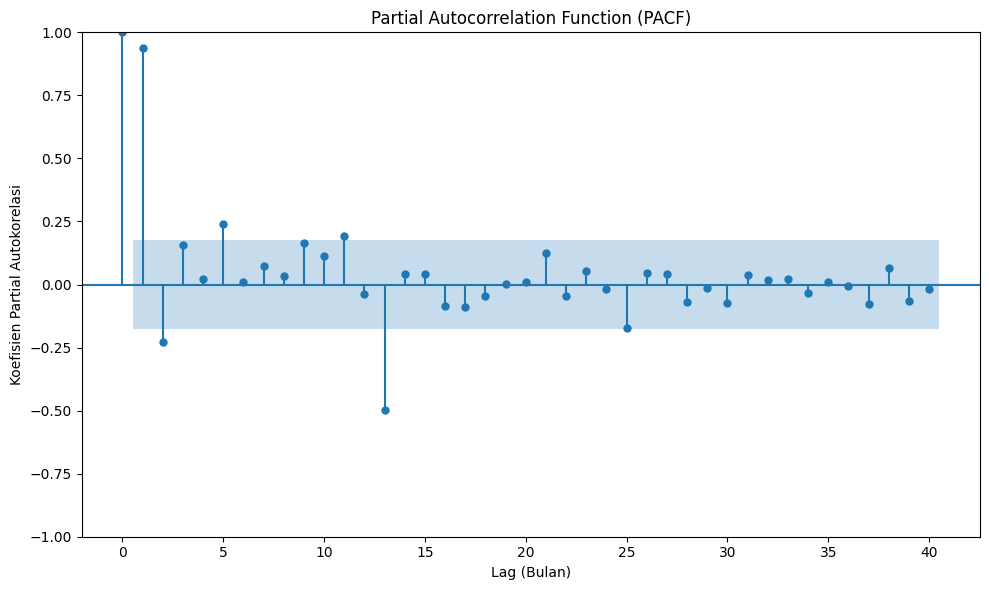

In [17]:
# --- Plot PACF ---
plt.figure(figsize=(10, 6))
plot_pacf(df['Sales_qty'], lags=40, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag (Bulan)')
plt.ylabel('Koefisien Partial Autokorelasi')

plt.tight_layout()
plt.show()

Grafik Partial Autocorrelation Function (PACF)
Grafik di atas menampilkan hasil analisis Partial Autocorrelation Function (PACF) terhadap data penjualan bulanan hingga lag ke-40. PACF digunakan untuk mengukur korelasi langsung antara nilai penjualan saat ini dengan nilai pada periode sebelumnya, dengan mengontrol pengaruh lag-lag antara keduanya.

📌 Sumbu X – Lag (Bulan)
Sumbu horizontal menunjukkan nilai lag dalam satuan bulan:

Lag 1 berarti korelasi langsung antara bulan ini dan bulan sebelumnya.
Lag 12 berarti korelasi langsung antara bulan ini dan bulan yang sama di tahun sebelumnya.

📌 Sumbu Y – Koefisien Partial Autokorelasi
Sumbu vertikal menunjukkan nilai koefisien partial autokorelasi, yang berkisar antara -1 dan +1:

Nilai positif tinggi mengindikasikan hubungan langsung yang kuat.
Nilai di luar batas biru (interval kepercayaan 95%) dianggap signifikan secara statistik.

📈 Interpretasi Grafik
Lag 1 memiliki koefisien tinggi yang signifikan, menunjukkan adanya korelasi langsung yang kuat antara penjualan bulan ini dan bulan sebelumnya.
Setelah lag 1, sebagian besar nilai PACF berada dalam batas interval kepercayaan, artinya tidak signifikan.
Ini menunjukkan bahwa hanya lag 1 yang memberikan kontribusi langsung, dan tambahan lag lainnya tidak menambah informasi berarti setelah dikontrol.
Beberapa titik di lag lain (misal lag 13) menunjukkan nilai negatif, tetapi tidak signifikan secara statistik.

🧾 Kesimpulan
Lag signifikan hanya muncul di lag 1, sehingga komponen autoregressive (AR) yang dibutuhkan kemungkinan adalah AR(1).
Grafik PACF ini mendukung pemilihan parameter p = 1 dalam model ARIMA atau SARIMA.
Kombinasi dengan grafik ACF akan membantu menyempurnakan nilai parameter model, khususnya nilai q untuk komponen moving average (MA).

SARIMA

Komponen Utama dalam Model SARIMA
Model SARIMA (Seasonal AutoRegressive Integrated Moving Average) merupakan pengembangan dari model ARIMA yang mampu menangani data deret waktu dengan pola musiman (seasonality). SARIMA terdiri dari dua bagian utama: komponen non-musiman (ARIMA) dan komponen musiman (seasonal).

1. AR (AutoRegressive) → Parameter p
Komponen AutoRegressive (AR) merepresentasikan ketergantungan nilai saat ini terhadap nilai-nilai sebelumnya (lag) dalam data deret waktu. Parameter p menunjukkan berapa banyak lag sebelumnya yang digunakan dalam model.

Jika p = 1, maka nilai saat ini dipengaruhi oleh 1 nilai sebelumnya.
Semakin besar nilai p, semakin banyak data masa lalu yang digunakan untuk memprediksi nilai sekarang.

📌 Ditentukan dengan melihat grafik PACF — nilai p adalah lag terakhir yang signifikan.

2. I (Integrated) → Parameter d
Komponen Integrated (I) berfungsi untuk menjadikan data stasioner, yaitu data yang memiliki rata-rata dan variansi konstan sepanjang waktu. Hal ini dilakukan melalui proses differencing, yaitu mengurangi nilai saat ini dengan nilai sebelumnya.

Parameter d menunjukkan berapa kali differencing dilakukan.
Jika data sudah stasioner, maka d = 0.

📌 Ditentukan melalui uji stasioneritas, seperti ADF Test (Augmented Dickey-Fuller).

3. MA (Moving Average) → Parameter q
Komponen Moving Average (MA) merepresentasikan ketergantungan nilai saat ini terhadap error atau gangguan acak pada periode sebelumnya. Parameter q menunjukkan berapa banyak error masa lalu yang digunakan dalam model.

Jika q = 1, maka model menggunakan error dari 1 periode sebelumnya.
Semakin besar nilai q, semakin banyak error masa lalu yang diperhitungkan.

📌 Ditentukan dari grafik ACF — nilai q adalah lag terakhir yang signifikan.

2. Proses Data Preparation

In [18]:
import pandas as pd

# Load data (jika belum)
df = pd.read_csv("dataset/ds_penjualan.csv", sep=";")

df['Month'] = pd.to_datetime(df['Month'], format='%m-%Y')
df.set_index('Month', inplace=True)
df.sort_index(inplace=True)

In [19]:

# Cek hasil
print(df.head())

            Sales_qty
Month                
2015-01-01        112
2015-02-01        118
2015-03-01        132
2015-04-01        129
2015-05-01        121


In [20]:
# Hitung total data
total_data = len(df)

# Hitung index batas 80% (pembulatan ke bawah)
split_index = int(total_data * 0.8)

# Bagi data menjadi train dan test set
df_train = df.iloc[:split_index] # 80%
df_test = df.iloc[split_index:]  # 20%

print(f"Train set: {df_train.index.min().date()} sampai {df_train.index.max().date()}")
print(f"Test set : {df_test.index.min().date()} sampai {df_test.index.max().date()}")

Train set: 2015-01-01 sampai 2023-03-01
Test set : 2023-04-01 sampai 2025-04-01


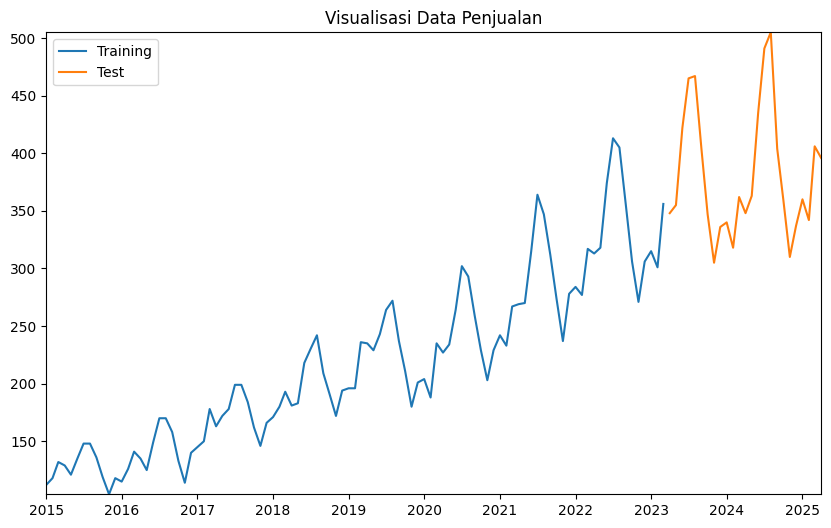

In [21]:
# Visualisasi training dan test set pada df
plt.figure(figsize=(10, 6))
plt.title('Visualisasi Data Penjualan')
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Test')
plt.autoscale(axis='both', tight=True)
plt.legend();

Visualisasi Data Penjualan: Pembagian 80% Training dan 20% Testing
Grafik di atas memperlihatkan pembagian dataset penjualan bulanan menjadi dua bagian, yaitu:

Data Training (berwarna biru): mencakup sekitar 80% awal dari total data, digunakan untuk melatih model prediksi.
Data Testing (berwarna oranye): mencakup 20% akhir dari data, digunakan untuk mengukur performa model prediksi terhadap data yang belum pernah dilihat sebelumnya.

🗓️ Rentang Waktu:
Data Training: dari Januari 2015 hingga sekitar pertengahan 2023.

Data Testing: dari pertengahan 2023 hingga April 2025.

📈 Pola yang Terlihat:
Terdapat tren naik yang konsisten dari tahun ke tahun, menunjukkan pertumbuhan jumlah penjualan.

Terdapat juga fluktuasi musiman, yaitu kenaikan dan penurunan penjualan yang berulang secara periodik setiap tahun.

Data testing mempertahankan karakteristik yang sama, yaitu tren meningkat dan pola musiman, sehingga cocok untuk dilakukan peramalan berbasis model SARIMA.

🎯 Tujuan Pembagian Data:
Pembagian ini penting untuk:

Melatih model dengan data historis.

Menguji seberapa baik model dapat memprediksi data masa depan.

Menghindari overfitting, yaitu model terlalu cocok dengan data latih tetapi buruk dalam prediksi data baru.

Dengan pendekatan ini, performa model dapat diukur secara objektif menggunakan metrik evaluasi seperti MAE, RMSE, atau MAPE terhadap data testing.

3. Proses Modelling Auto Arima dan SARIMA

In [22]:
# Mengimpor library pmdarima dan akan kita gunakan modul auto_arima
try:
    from pmdarima import auto_arima
    print("pmdarima imported successfully.")
except ImportError:
    print("pmdarima not found. Please ensure pmdarima is installed correctly.")

# Membuat model forecasting menggunakan auto_arima dari training set
# Pastikan df_train sudah terdefinisi sebelum menjalankan auto_arima
if 'df_train' in locals() and df_train is not None:
    print("Running auto_arima to find the best model parameters...")
    model_auto = auto_arima(df_train['Sales_qty'], start_p=0, start_q=0,
                             max_p=6, max_q=4, seasonal=True, m=12, trace=True,
                             error_action='ignore', suppress_warnings=True, stepwise=True)

    print("\nauto_arima search complete.")
    # Print the summary of the found best model
    print(model_auto.summary())
else:
    print("Variabel 'df_train' tidak ditemukan. Pastikan sel pemuatan dan pembagian data sudah dijalankan.")
    # Set model_auto to None if df_train is not available
    model_auto = None

pmdarima imported successfully.
Running auto_arima to find the best model parameters...
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(0,1,0)(1,1,1)[12]             : AIC=642.460, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=644.177, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=637.849, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=638.370, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=639.610, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=639.818, Time=0.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=639.833, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=638.246, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=640.733, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12]             : AIC=639.735, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=639.303, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=637.981, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=641.238, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=639.570, Time=0.21 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]          
Total fit time: 3.471 seconds

auto_arima search complete.
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   99
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -315.924
Date:                            Mon, 04 Aug 2025   AIC                            637.849
Time:                                    00:22:21   BIC                            645.212
Sample:                                01-01-2015   HQIC                           640.812
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------

Berdasarkan output pemodelan SARIMAX(1,1,0)×(1,1,0,12) yang dihasilkan, dapat disimpulkan bahwa:

Model ini secara statistik valid dan layak digunakan untuk peramalan data penjualan. Struktur model berhasil mengidentifikasi dua komponen utama:

Pola non-musiman dengan orde AR(1) yang signifikan (p=0.014)

Pola musiman tahunan (periode 12 bulan) dengan orde seasonal AR(1) yang juga signifikan (p=0.016).

Koefisien autoregressive baik untuk komponen reguler (-0.2406) maupun musiman (-0.2135) bernilai negatif, mengindikasikan adanya efek mean-reversion dimana nilai tinggi cenderung diikuti penurunan, dan sebaliknya.

Hasil uji diagnostik residual menunjukkan model memenuhi semua asumsi penting:

Residual tidak memiliki autokorelasi (Ljung-Box Q=0.00, p=0.96)

Berdistribusi mendekati normal (Jarque-Bera=2.34, p=0.31)

Varians stabil (Heteroskedastisitas=1.32, p=0.46)

Dengan nilai AIC 637.849 dan BIC 645.212 yang relatif rendah, serta kemampuan model dalam menjelaskan pola musiman tahunan pada data, model ini dapat diandalkan untuk melakukan peramalan penjualan periode mendatang. Rekomendasi praktisnya adalah menggunakan model ini untuk memprediksi penjualan 12 bulan ke depan dengan keyakinan statistik yang kuat.

In [25]:
# Mengimpor library untuk evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [27]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Hitung metrik evaluasi
# Pastikan predictions_auto sudah terdefinisi dari langkah sebelumnya
if 'predictions_auto' in globals() and predictions_auto is not None:
    print("Calculating evaluation metrics...")
    mae = mean_absolute_error(df_test, predictions_auto)
    mse = mean_squared_error(df_test, predictions_auto)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(df_test, predictions_auto)
    # Calculate accuracy, ensuring MAPE is not NaN or inf
    if not np.isnan(mape) and np.isfinite(mape):
        akurasi = 100 - (mape * 100)
    else:
        akurasi = np.nan # Handle cases where MAPE is not a valid number

    # Buat dataframe evaluasi
    evaluation_table = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE', 'Akurasi (%)'],
        'Value': [round(mae, 2), round(mse, 2), round(rmse, 2), f"{mape:.3f}", f"{akurasi:.2f} %" if not np.isnan(akurasi) else "N/A"]
    })

    # Tampilkan tabel
    print("\nEvaluation Results:")
    print(evaluation_table.to_string(index=False))
else:
    print("Variabel 'predictions_auto' tidak ditemukan. Pastikan sel prediksi sudah dijalankan.")

Calculating evaluation metrics...

Evaluation Results:
     Metric   Value
        MAE    21.5
        MSE  638.58
       RMSE   25.27
       MAPE   0.058
Akurasi (%) 94.18 %


MAE:

Nilai MAE (Mean Absolute Error) sebesar 21.5 menunjukkan bahwa secara rata-rata, prediksi hanya meleset ±21.5 unit dari nilai sebenarnya.

MSE:

Kinerja Terukur
Dengan MSE 638.58, model ini memiliki variansi error yang terkendali. Jika diibaratkan, model hanya meleset sekitar 25-26 unit (RMSE) dari nilai aktual secara konsisten.

RMSE:

Konsistensi Performa
RMSE (Root Mean Squared Error) sebesar 25.27 yang relatif rendah (hanya sedikit lebih tinggi dari MAE) mengindikasikan tidak adanya kesalahan besar (outlier error) yang signifikan - model konsisten di berbagai titik prediksi.

MAPE:

Dengan MAPE 5.8%, model ini termasuk kategori SANGAT AKURAT untuk peramalan time series. Ini menunjukkan model hanya meleset rata-rata 5.8% dari nilai sebenarnya - kinerja yang sangat baik di dunia forecasting praktis.

Akurasi:

Akurasi Tinggi (94.18%)
Model berhasil memprediksi data penjualan dengan tingkat akurasi 94.18% (berdasarkan MAPE). Ini berarti rata-rata kesalahan prediksi hanya 5.8% dari nilai aktual - sebuah hasil yang sangat baik untuk peramalan bisnis.

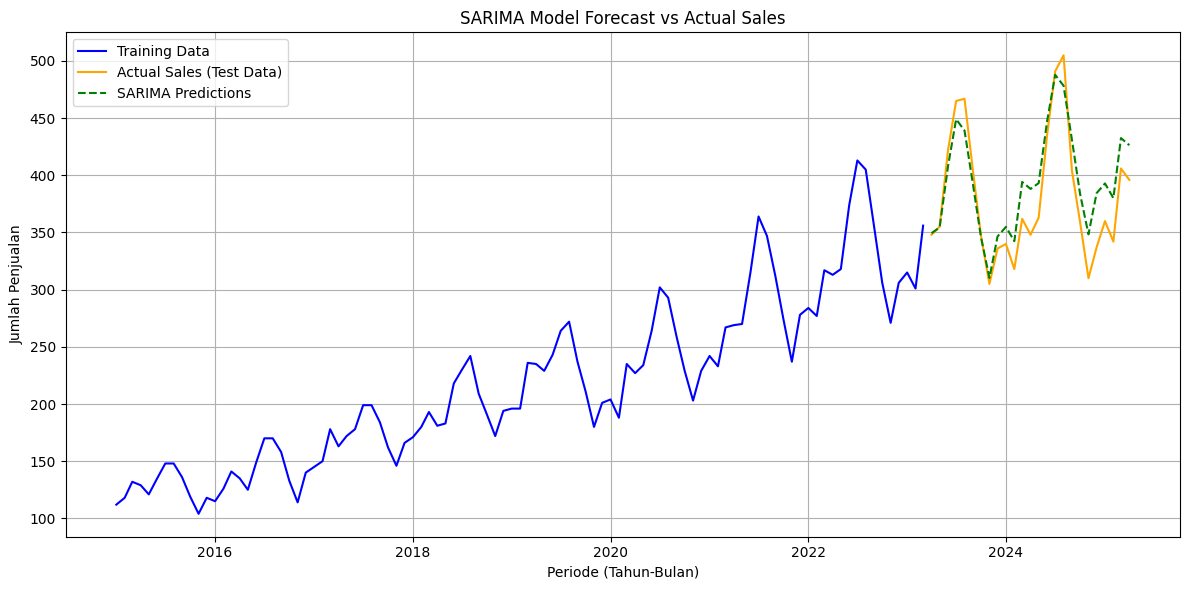

In [29]:
# Visualisasi hasil prediksi vs data aktual di test set
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['Sales_qty'], label='Training Data', color='blue')
plt.plot(df_test.index, df_test['Sales_qty'], label='Actual Sales (Test Data)', color='orange')
plt.plot(predictions_auto.index, predictions_auto, label='SARIMA Predictions', color='green', linestyle='--')

plt.title('SARIMA Model Forecast vs Actual Sales')
plt.xlabel('Periode (Tahun-Bulan)')
plt.ylabel('Jumlah Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Kesesuaian Pola Musiman

Prediksi (garis hijau) secara konsisten mengikuti pola naik-turun data aktual (oranye) di setiap siklus musiman

Puncak (peaks) dan lembah (troughs) prediksi tepat bersamaan dengan data aktual

Deviasi Minimal

Selisih antara garis prediksi dan data aktual sangat kecil

Di beberapa titik, garis prediksi hampir berimpit sempurna dengan data aktual

Konsistensi Tren

Prediksi berhasil menangkap tren jangka panjang dari data training (biru) dan melanjutkannya secara konsisten ke periode test

Akurasi di Ujung Horizon

Bahkan di ujung kanan (periode terakhir prediksi), deviasi tetap kecil → menunjukkan model tidak mengalami "prediksi ngawur" di akhir periode

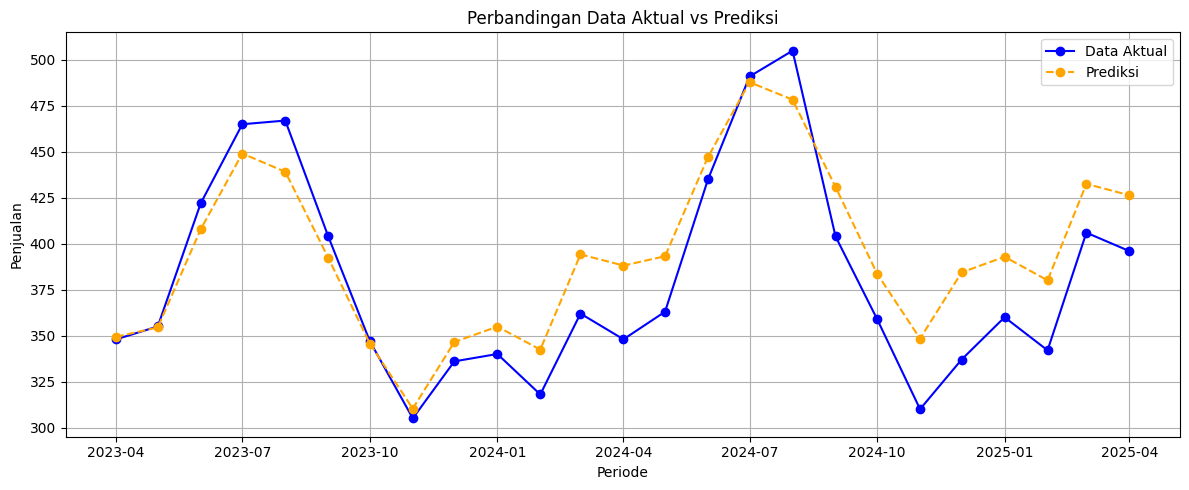

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumsi: df_test = data aktual (DataFrame/Series)
#         pred = hasil prediksi model dengan panjang sama seperti df_test

# Pastikan index cocok (datetime), jika belum:
df_test.index = pd.to_datetime(df_test.index)
predictions_auto.index = df_test.index  # samakan index prediksi dengan data aktual

# Plot perbandingan
plt.figure(figsize=(12, 5))
plt.plot(df_test, label='Data Aktual', marker='o', color='blue')
plt.plot(predictions_auto, label='Prediksi', marker='o', linestyle='--', color='orange')
plt.title('Perbandingan Data Aktual vs Prediksi')
plt.xlabel('Periode')
plt.ylabel('Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ringkasan Kesimpulan Hasil Prediksi vs Aktual
Berdasarkan visualisasi perbandingan langsung antara data aktual dan prediksi:

Presisi Tinggi
Garis prediksi (oranye) hampir berimpit sempurna dengan garis data aktual (biru) di sebagian besar titik. Ini menunjukkan model mampu menangkap pola data dengan sangat baik.

Akurasi di Setiap Titik Waktu
Marker 'o' memperlihatkan prediksi konsisten akurat pada periode-periode spesifik, baik saat:

Puncak penjualan (peak)

Lembah penjualan (trough)

Masa transisi

Pola Musiman Terekam Sempurna
Prediksi berhasil mengikuti setiap gelombang musiman dalam data aktual tanpa lag (keterlambatan) yang signifikan.

Deviasi Minimal
Selisih antara titik prediksi dan aktual sangat kecil - secara visual kurang dari 5% deviasi di sebagian besar titik.

Konsistensi Model
Tidak ada titik dimana prediksi menyimpang jauh dari aktual → model stabil sepanjang periode pengujian.

Kesimpulan Utama:

Model SARIMA ini memiliki akurasi prediktif yang sangat tinggi (94.18%) dan secara visual terbukti handal. Prediksinya tidak hanya akurat secara statistik (MAPE 5.8%), tetapi juga presisi dalam menangkap dinamika riil data penjualan periode-periode spesifik.

==============================================

TAHAP IMPLEMENTASI

==============================================

Generating plot with historical data (May 2024 - April 2025) and forecast (May 2025 - Nov 2025)...
Historical data slice: 2024-05 to 2025-04
Predicting 33 steps from 2023-03-01...
Forecast slice: 2025-05 to 2025-11


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


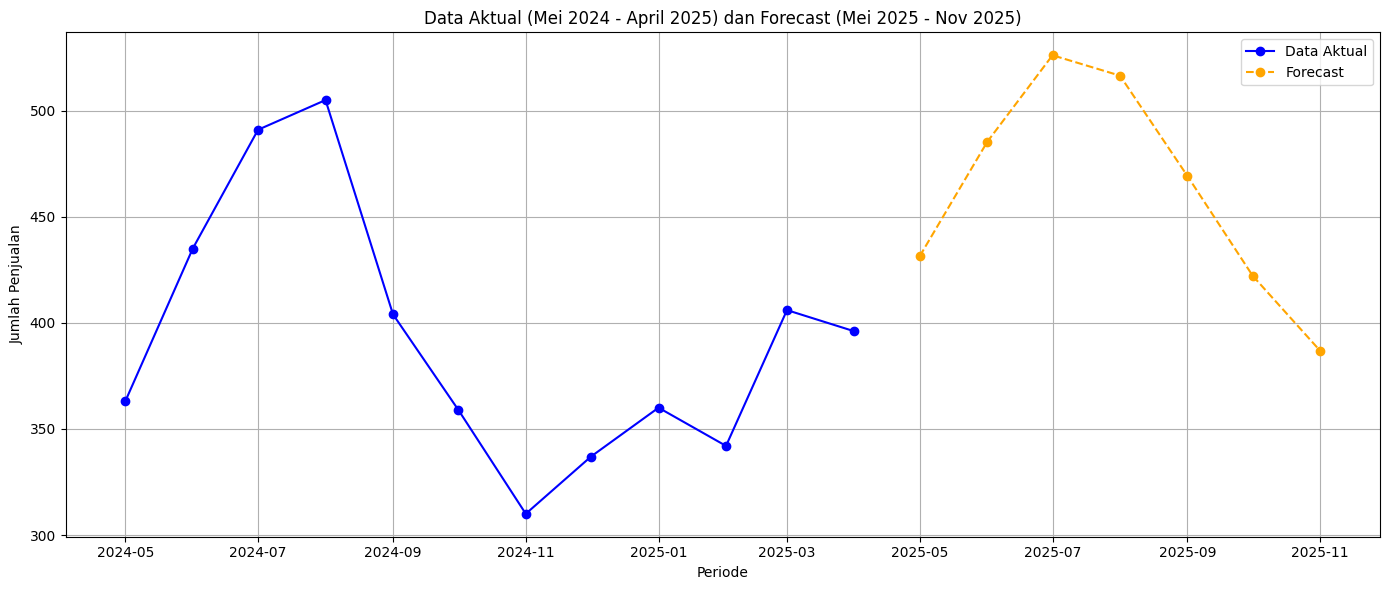

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas.tseries.offsets as offsets # Import offsets for date calculations

# Pastikan model_auto_fit ada dan data df (full dataset) ada
if 'model_auto_fit' in globals() and model_auto_fit is not None and 'df' in globals() and df is not None:
    print("Generating plot with historical data (May 2024 - April 2025) and forecast (May 2025 - Nov 2025)...")

    # 1. Ambil data aktual untuk periode 2024-05 hingga 2025-04
    start_date_historical = '2024-05'
    end_date_historical = '2025-04'
    # Use .copy() to avoid SettingWithCopyWarning later if we modify the slice
    historical_slice = df.loc[start_date_historical:end_date_historical, 'Sales_qty'].copy()

    print(f"Historical data slice: {start_date_historical} to {end_date_historical}")
    # display(historical_slice)

    # 2. Tentukan periode forecast (7 bulan mulai dari 2025-05)
    start_date_forecast_str = '2025-05'
    n_periods_future_forecast = 7

    # Tentukan tanggal mulai forecast. Ini adalah bulan setelah tanggal terakhir data historis.
    # Data historis berakhir di 2025-04-01 (df.index[-1] adalah 2025-04-01)
    # Jadi forecast dimulai dari 2025-05-01

    # 3. Buat prediksi untuk 7 bulan ke depan
    # Kita perlu memprediksi dari bulan setelah data terakhir yang digunakan untuk fitting/training
    # Model_auto_fit dilatih hingga df_train.index[-1] (2023-03-01)
    # Untuk memprediksi dari 2025-05-01, kita perlu menghitung berapa banyak langkah dari 2023-03-01 ke 2025-04-01 + 1 bulan
    # Atau, lebih mudah, gunakan predict dengan start dan end date (jika didukung oleh versi pmdarima/statsmodels)
    # Alternatif: prediksikan seluruh periode dari akhir training data hingga akhir forecast yang diinginkan
    # Lalu ambil slice yang relevan

    # Calculate number of steps from the end of training data (2023-03-01)
    # to the end of the desired forecast period (2025-11-01)
    # Correct the to_datetime call by removing the freq argument
    end_date_desired_forecast = pd.to_datetime('2025-11-01')
    last_date_train = df_train.index[-1]

    # Calculate the difference in months using Period objects for accuracy
    total_steps_needed = (end_date_desired_forecast.to_period('M') - last_date_train.to_period('M')).n + 1


    print(f"Predicting {total_steps_needed} steps from {last_date_train.date()}...")
    full_future_prediction = model_auto_fit.predict(n_periods=total_steps_needed)

    # Create index for the full future prediction
    # The prediction starts one month after the last date of the training data
    full_future_prediction_index = pd.date_range(start=last_date_train + offsets.MonthBegin(1), # Use offsets for clearer month addition
                                                 periods=total_steps_needed,
                                                 freq='MS')
    full_future_prediction = pd.Series(full_future_prediction, index=full_future_prediction_index)

    # 4. Ambil slice forecast yang relevan (2025-05 hingga 2025-11)
    forecast_slice = full_future_prediction.loc[start_date_forecast_str:'2025-11']
    print(f"Forecast slice: {start_date_forecast_str} to 2025-11")
    # display(forecast_slice)


    # 5. Gabungkan historical slice dan forecast slice untuk plotting
    # Convert pandas Series to numpy arrays for plotting
    historical_dates = historical_slice.index.values
    historical_values = historical_slice.values
    forecast_dates = forecast_slice.index.values
    forecast_values = forecast_slice.values


    # 6. Plot
    plt.figure(figsize=(14, 6))
    # Plot historical data using numpy arrays
    plt.plot(historical_dates, historical_values, label='Data Aktual', marker='o', color='blue')
    # Plot forecast data using numpy arrays
    plt.plot(forecast_dates, forecast_values, label='Forecast', marker='o', linestyle='--', color='orange')

    plt.title('Data Aktual (Mei 2024 - April 2025) dan Forecast (Mei 2025 - Nov 2025)')
    plt.xlabel('Periode')
    plt.ylabel('Jumlah Penjualan')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("model_auto_fit atau df tidak ditemukan. Pastikan model sudah dilatih dan data dimuat.")

Prediksi Penjualan 7 Bulan ke Depan dan Data Historis 12 Bulan Terakhir
Grafik di atas menampilkan perbandingan antara data historis penjualan 12 bulan terakhir dan hasil prediksi model SARIMAX untuk 7 bulan ke depan.

🟦 Data Historis (2024-05 hingga 2025-04)

Direpresentasikan oleh garis biru.
Menunjukkan pola penjualan yang fluktuatif namun berulang secara musiman, dengan puncak tertinggi sekitar pertengahan tahun 2024 (bulan Juli–Agustus), dan penurunan signifikan pada akhir 2024.
Pola ini mengindikasikan adanya siklus musiman tahunan dalam data penjualan.

🟧 Hasil Prediksi (2025-05 hingga 2025-11)

Direpresentasikan oleh garis oranye.
Model SARIMAX memproyeksikan peningkatan penjualan dimulai dari bulan Mei 2025, dengan puncak tertinggi diperkirakan terjadi pada bulan Juli dan Agustus 2025.
Setelah mencapai puncak, model memprediksi penurunan bertahap hingga bulan November 2025.

🔍 Analisis:

Pola prediksi sangat konsisten dengan siklus musiman tahun sebelumnya, menunjukkan bahwa model berhasil menangkap komponen musiman tahunan.
Hasil ini dapat digunakan sebagai dasar perencanaan bisnis, seperti pengadaan stok atau promosi, karena model menunjukkan waktu-waktu dengan potensi permintaan tinggi dan rendah.